In [1]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.pyplot import colormaps as cmaps
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu as mwu

import src
from src import vis

FILE_IN = "data/final/snrna_variant_counts.tsv"
PNG = "data/plots/snrna_variant_density.png"
SVG = "data/plots/snrna_variant_density.svg"

In [2]:
df_density = (
    pd.read_csv(
        FILE_IN,
        sep="\t",
        usecols=["symbol", "allele_type", "gene_type", "variants_per_nt"],
    )
    .assign(
        allele_type=lambda x: pd.Categorical(
            x.allele_type, categories=["SNV", "Indel"], ordered=True
        ),
        gene_type=lambda x: pd.Categorical(
            x.gene_type, categories=["snRNA", "Pseudogene"], ordered=True
        ),
    )
    .sort_values(["allele_type", "gene_type", "variants_per_nt"])
)

In [3]:
# Top 5 genes for variant density
for group, data in df_density.groupby(["allele_type", "gene_type"], sort=False):
    data.check.function(
        lambda x: x.nlargest(3, "variants_per_nt"),
        check_name=f"Greatest variant density {group}:",
    )

/tmp/ipykernel_195169/2059760522.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, data in df_density.groupby(["allele_type", "gene_type"], sort=False):


<h5 style='text-align: left'><span style='color:None; background-color:None'>Greatest variant density ('SNV', 'snRNA'):</span></h5>

,allele_type,symbol,gene_type,variants_per_nt
43,SNV,RNU5E-1,snRNA,2.231
256,SNV,RNU5D-1,snRNA,2.225
2218,SNV,RNU7-1,snRNA,2.032


<h5 style='text-align: left'><span style='color:None; background-color:None'>Greatest variant density ('SNV', 'Pseudogene'):</span></h5>

,allele_type,symbol,gene_type,variants_per_nt
857,SNV,RNU5E-6P,Pseudogene,1.861
1827,SNV,RNU2-2P,Pseudogene,1.843
480,SNV,RNU5A-8P,Pseudogene,1.684


<h5 style='text-align: left'><span style='color:None; background-color:None'>Greatest variant density ('Indel', 'snRNA'):</span></h5>

,allele_type,symbol,gene_type,variants_per_nt
2217,Indel,RNU7-1,snRNA,0.508
42,Indel,RNU5E-1,snRNA,0.463
1503,Indel,RNU6-9,snRNA,0.439


<h5 style='text-align: left'><span style='color:None; background-color:None'>Greatest variant density ('Indel', 'Pseudogene'):</span></h5>

,allele_type,symbol,gene_type,variants_per_nt
2529,Indel,RNU6-758P,Pseudogene,0.551
2105,Indel,RNU6-437P,Pseudogene,0.432
2271,Indel,RNU6-1218P,Pseudogene,0.407


In [4]:
# Group variant density statistics
for group, data in df_density.groupby(["allele_type", "gene_type"], sort=False):
    data.check.function(
        lambda x: x["variants_per_nt"].agg(["mean", "median"]), check_name=f"{group}:"
    )

/tmp/ipykernel_195169/541201131.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, data in df_density.groupby(["allele_type", "gene_type"], sort=False):


<h5 style='text-align: left'><span style='color:None; background-color:None'>('SNV', 'snRNA'):</span></h5>

,variants_per_nt
mean,0.596
median,0.314


<h5 style='text-align: left'><span style='color:None; background-color:None'>('SNV', 'Pseudogene'):</span></h5>

,variants_per_nt
mean,0.211
median,0.206


<h5 style='text-align: left'><span style='color:None; background-color:None'>('Indel', 'snRNA'):</span></h5>

,variants_per_nt
mean,0.088
median,0.037


<h5 style='text-align: left'><span style='color:None; background-color:None'>('Indel', 'Pseudogene'):</span></h5>

,variants_per_nt
mean,0.026
median,0.019


In [5]:
# Gene counts
df_gene_counts = (
    pd.DataFrame(
        {"snRNA": 120, "Pseudogene": 1778},
        index=["count"],
    )
    .T.assign(
        pct=lambda x: (x["count"] / x["count"].sum()).map("{:.2%}".format),
        label=lambda x: x["count"].astype(str) + "\n(" + x["pct"] + ")",
    )
    .check.head()
)

<h5 style='text-align: left'><span style='color:None; background-color:None'>First 5 rows</span></h5>

,count,pct,label
snRNA,120,6.32%,120 (6.32%)
Pseudogene,1778,93.68%,1778 (93.68%)


Two-sided Mann Whitney U test (SNV): P=3.1e-09
Two-sided Mann Whitney U test (Indel): P=6.18e-13


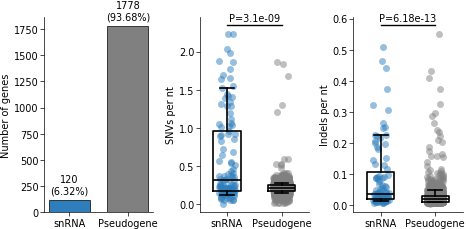

In [6]:
plt.style.use("src/default.mpltstyle")
fig, axs = plt.subplots(1, 3, figsize=(12 / 2.54, 6 / 2.54), constrained_layout=True)

box_linewidth = 1.2
color_snrna = cmaps["Blues"](0.7)
color_pseudo = "grey"
colors = [color_snrna, color_pseudo]
dfg_variant_type = df_density.groupby("allele_type", observed=True)
ax_labels = ["SNVs per nt", "Indels per nt"]

# Bar chart
bar = axs[0].bar(
    df_gene_counts.index,
    df_gene_counts["count"],
    color=[color_snrna, color_pseudo],
    edgecolor="black",
    lw=0.5,
    width=0.7,
)
axs[0].bar_label(bar, labels=df_gene_counts["label"], padding=3)
axs[0].set_ylabel("Number of genes")

for ax, (variant_type, data), label in zip(axs[1:], dfg_variant_type, ax_labels):
    dfg_gene_type = data.groupby("gene_type", observed=True, sort=False)

    for (i, (gene_type, d)), c in zip(enumerate(dfg_gene_type), colors):
        d = d.copy()
        n = len(d)
        d["x"] = i + np.random.uniform(-0.15, 0.15, n)
        x = d["x"]
        y = d["variants_per_nt"]
        ax.boxplot(
            y,
            positions=[i],
            widths=[0.5],
            showfliers=False,
            boxprops=dict(color="black", lw=1.2),
            medianprops=dict(color="black", lw=1.2),
            whiskerprops=dict(color="black", lw=1.2),
            capprops=dict(color="black", lw=1.2),
            tick_labels=[gene_type],
            whis=[10, 90],
            zorder=10,
        )
        scatter = ax.scatter(x, y, alpha=0.5, lw=0, color=c, s=25)

    # Customize axes
    ax.set_ylabel(label)

    # Add significance labels
    snrna_density = data.loc[lambda x: x["gene_type"] == "snRNA", "variants_per_nt"]
    pseudo_density = data.loc[
        lambda x: x["gene_type"] == "Pseudogene", "variants_per_nt"
    ]

    p = mwu(snrna_density, pseudo_density, alternative="two-sided").pvalue
    p_label = f"P={p:.3n}"
    print(f"Two-sided Mann Whitney U test ({variant_type}): {p_label}")

    vis.annotate_stats_horizontal_line(p_label, 0, 1, ax=ax)

# Save figure
plt.savefig(PNG, dpi=600)
plt.savefig(SVG)